# Eurosat LUC With Pretrained Models

### Config for data paths and terminal colors

In [1]:
class Config:
    DATA_DIR = '../data/euroSat/'
    TRAIN_FILE = DATA_DIR + 'train.csv'
    TEST_FILE = DATA_DIR + 'test.csv'
    SAMPLE_SUBMISSION_FILE = DATA_DIR + 'sample_submission.csv'
    TRAIN_RGB_DIR = DATA_DIR + 'train/EuroSAT_RGB/'
    TRAIN_MS_DIR = DATA_DIR + 'train/EuroSAT_MS/'

    TEST_MS_DIR = DATA_DIR + 'test/NoLabel/'
    MEAN_STD_FILE = "tmp/eurosat_ms_mean_std"
    MEAN_STD_FILE_L2C = "tmp/eurosat_ms_mean_std_L2C"
    MEAN_STD_FILE_L2A = "tmp/eurosat_ms_mean_std_L2A"
    TEST_LABELD_FILE = "tmp/labels.csv"

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

c = bcolors()
config = Config()

### Helper functions for loading pickle data

In [2]:
import pickle

def load_object(fname):
    try:
        with open(fname + ".pickle", "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)


def save_object(obj, fname):
    try:
        with open(fname + ".pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

In [3]:
class EuroSatIndexes:
    def __init__(self, arr):
        self.arr = arr
        self.image = []

    def compute_ndvi(self):
        # (Band8 - Band4) / (Band8 + Band4)
        result = (self.arr[7] - self.arr[3]) / (self.arr[7] + self.arr[3] + 1e-7)
        self.image.append(result)

    def compute_ci(self):
        # (Band8 - Band3) / (Band8 + Band3)
        result = (self.arr[7] - self.arr[2]) / (self.arr[7] + self.arr[2] + 1e-7)
        self.image.append(result)

    def compute_ri(self):
        # Band4 / Band3
        result = self.arr[3] / (self.arr[2] + 1e-7)
        self.image.append(result)

    def compute_ndbi(self):
        # (Band11 - Band8) / (Band11 + Band8)
        result = (self.arr[10] - self.arr[7]) / (self.arr[10] + self.arr[7] + 1e-7)
        self.image.append(result)

    def compute_savi(self):
        # ((Band8 - Band4) / (Band8 + Band4 + L)) * (1 + L)
        L = 0.5  # Adjustment constant
        result = ((self.arr[7] - self.arr[3]) / (self.arr[7] + self.arr[3] + L + 1e-7)) * (1 + L)
        self.image.append(result)

    def compute_gli(self):
        # Band3 / Band2
        result = self.arr[2] / (self.arr[1] + 1e-7)
        self.image.append(result)

    def compute_gci(self):
        # (Band8 - Band3) / (Band8 + Band3)
        result = (self.arr[7] - self.arr[2]) / (self.arr[7] + self.arr[2] + 1e-7)
        self.image.append(result)

    def compute_bsi(self):
        # (Band11 + Band12) / (Band8 + Band4)
        result = (self.arr[10] + self.arr[11]) / (self.arr[7] + self.arr[3] + 1e-7)
        self.image.append(result)
    
    def compute_ndwi(self):
        # (Band3 - Band8) / (Band3 + Band8)
        result = (self.arr[2] - self.arr[7]) / (self.arr[2] + self.arr[7] + 1e-7)
        self.image.append(result)


### Defining the Dataset & Datamodule

In [4]:
from skimage.exposure import exposure
# import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2

def histogram_equalize(image):
    for i in range(image.shape[0]):
        image[i] = exposure.equalize_hist(image[i], nbins=40000)
    return image

def merge_stack_channels_tensor(image, channel_map):
    batch_size, num_channels, height, width = image.shape
    new_images = []
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    for i in range(batch_size):
        new_image = torch.zeros((3, height * 2, width * 2))
        for row in range(2):
            for col in range(2):
                channels = channel_map[row * 2 + col]
                new_image[:, row * height:(row + 1) * height, col * width:(col + 1) * width] = \
                    image[i, channels, :, :]
        new_images.append(new_image)
    return torch.stack(new_images)

In [5]:
import os
import sys
import time

import numpy as np
import rasterio
import kornia.augmentation as K
from joblib import Parallel, delayed
from torch.utils.data import Dataset
from torchvision import transforms


class EuroSatMS(Dataset):
    
    def __init__(self,
                 dataframe,
                 root_dir,
                 encoder,
                 select_chan=None,
                 hist_eq=False,
                 dstype="train",
                 n_jobs=-4):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.select_chan = select_chan
        self.dstype = dstype
        self.hist_eq = hist_eq

        self.enc = encoder

        print(f"\n{c.OKGREEN}Preloading images...{c.ENDC}")
        print(f"\n{c.OKCYAN}Images:         {len(dataframe)}{c.ENDC}")
        print(f"{c.OKCYAN}Jobs:           {n_jobs} {c.ENDC}\n")

        start_time = time.time()
        result = Parallel(n_jobs=n_jobs)(
            delayed(self.process_image)(idx) for idx in range(len(dataframe))
        )

        self.samples = np.array([x for x, _, _ in result], dtype=np.float32)
        self.targets = np.array([y for _, y, _ in result])
        self.groups = np.array([z for _, _, z in result])
        
        # self.samples = torch.tensor(self.samples, dtype=torch.float32)
        # self.targets = torch.tensor(self.targets, dtype=torch.float32)
        
        end_time = time.time()
        t = end_time - start_time
        print(f"\n{c.OKBLUE}Time taken:      {int((t - (t % 60)) / 60)} min {t % 60} sec {c.ENDC}")

    def process_image(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])

        if ".npy" in img_path:
            image = np.load(img_path).transpose(2, 0, 1)
        else:
            with rasterio.open(img_path) as src:
                image = np.array(src.read())
        
        image = image[self.select_chan].astype(np.float32)
        
        if self.dstype == "train":
            target = self.dataframe.iloc[idx, 1]
            target = self.enc.transform(np.array([target]).reshape(-1, 1)).toarray()
            target = target.flatten().astype(np.float32)
        else:
            target = int(self.dataframe.iloc[idx, 0].split("_")[1].split(".")[0])
        
        # es_idx = EuroSatIndexes(image)
        # 
        # es_idx.compute_ndvi()
        # es_idx.compute_ndbi()
        # es_idx.compute_savi()
        # es_idx.compute_ndwi()
        # es_idx.compute_bsi()
        # 
        # image = np.array(es_idx.image)
        
        # if self.hist_eq:
        #     image = histogram_equalize(image)
        # else:
        #     rgb_max, rgb_min = image.max(), image.min()
        #     image = (image - rgb_min) / (rgb_max - rgb_min + 1e-7)
        
        
        
        return image, target, idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, samp_idx):
        if torch.is_tensor(samp_idx):
            samp_idx = samp_idx.tolist()
        
        image = self.samples[samp_idx]
        target = self.targets[samp_idx]
        
        if self.hist_eq:
            image = histogram_equalize(image)
            
        image = torch.tensor(image, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
            
        return image, target

In [34]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import random


class EuroSatDataLoader(DataLoader):
    LAMBDA_RANGE = (0, 1)
    def __init__(self, ds, batch_size=1, shuffle=False, mixup=True, num_workers=0, tf=None, augment=None):
        super(EuroSatDataLoader, self).__init__(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.transform = tf
        self.augment = augment
        self.mixup = mixup
        
    def mixup_image_batch(self, samp_images, samp_targets):
        _, labels = torch.max(samp_targets, 1)
        mixup = K.RandomMixUpV2(data_keys=["input", "class"], lambda_val=self.LAMBDA_RANGE, p=1)

        input_data, mixing_label = mixup(samp_images, labels)
                
        lam_vals = mixing_label[:, 2]
        mix_idx = mixing_label[:, 1].numpy().astype(int)
        org_idx = mixing_label[:, 0].numpy().astype(int)
    
        for i in range(len(samp_targets)):
            samp_targets[i, org_idx[i]] = samp_targets[i, org_idx[i]] - lam_vals[i]
            samp_targets[i, mix_idx[i]] = samp_targets[i, mix_idx[i]] + lam_vals[i]
        
        return input_data, samp_targets

    def __iter__(self):
        for batch_sample in super().__iter__():
            input_data = batch_sample[0]
            class_label = batch_sample[1]
            
            if self.transform:
                input_data = self.transform(input_data)
                input_data.clamp_(-2.5, 2.5)
                
            if self.augment:
                input_data = self.augment((input_data + 2.5) / 5) * 5 - 2.5
            
            if self.mixup:
                if random.random() < 0.75:
                    input_data, class_label = self.mixup_image_batch(input_data, class_label)
            
            yield input_data, class_label
            

class EuroSatDataModule(pl.LightningDataModule):
    def __init__(self, dataset_train, dataset_val, dataset_test, batch_size, tf_L2C=None, tf_L2A=None, augment=None, num_workers=8):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset_train = dataset_train
        self.dataset_val = dataset_val
        self.dataset_test = dataset_test
        
        self.transform_L2C = tf_L2C
        self.transform_L2A = tf_L2A
        self.augment = augment
        
    def train_dataloader(self):
        return EuroSatDataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, mixup=True, num_workers=self.num_workers, tf=self.transform_L2C, augment=self.augment)

    def val_dataloader(self):
        return EuroSatDataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False, mixup=True, num_workers=self.num_workers, tf=self.transform_L2A)

    def test_dataloader(self):
        return EuroSatDataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False, mixup=True, num_workers=self.num_workers, tf=self.transform_L2C)


## Model Definition
### Function for loading a pretrained model with its transforms

In [7]:
from torch import nn


#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout2d(dropout_p)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, dropout_p, in_channels, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.dropout_p = dropout_p
        self.conv = conv3x3(in_channels, 16)
        self.bn = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, layers[0], 1)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(16)
        
        # compute the number of features
        rand_sample = torch.randn(1, in_channels, 64, 64)
        out = self.conv(rand_sample)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        self.num_features = out.size(1)
        self.fc = nn.Linear(self.num_features, num_classes)
        
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, self.dropout_p, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, self.dropout_p))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

### Pytorch Lightning Model Class

# Loading The Dataset
## Setting parameters

- **PRETRAINED_MODEL**: Name of the model to use.
- **CHANNELS_2C**: Channels to select for L2C data.
- **CHANNELS_2A**: Channels to use for L2A data.
- **NUM_CLASSES**: Number of classes to predict.

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

CHANNELS_2C = [3, 2, 1, 7] # [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]
CHANNELS_2A = [3, 2, 1, 7]
NUM_CLASSES = 10
TEST_SPLIT = 0.05

## Load metadata description, encode labels and get transforms for model

In [10]:
df = pd.read_csv(config.TRAIN_FILE)
df_val = pd.read_csv(config.TEST_LABELD_FILE)
print(np.unique(df[['label']].values))
encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, config.DATA_DIR + "on_hot_encoder")

obj_L2C = load_object(config.MEAN_STD_FILE_L2C)
obj_L2A = load_object(config.MEAN_STD_FILE_L2A)

data_transforms_l2a = transforms.Compose([
    K.Resize(64),
    K.Normalize(obj_L2A['mean'][CHANNELS_2A], obj_L2A['std'][CHANNELS_2A])
])

data_transforms_l2c = transforms.Compose([
    K.Resize(64),
    K.Normalize(obj_L2C['mean'][CHANNELS_2C], obj_L2C['std'][CHANNELS_2C])
])

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


## Initialize the dataset for train, test and validation

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=TEST_SPLIT, stratify=df['label'])

ds_train = EuroSatMS(
    train_df,
    config.TRAIN_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2C,
    hist_eq=False
)

ds_val = EuroSatMS(
    df_val,
    config.TEST_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2A,
    hist_eq=False
)

ds_test = EuroSatMS(
    test_df.head(100),
    config.TRAIN_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2C,
    hist_eq=False
)

print(f"""\n{c.OKGREEN}Train dataset:      {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")


Preloading images...

Images:         25650
Jobs:           -4 


Time taken:      6 min 49.12582325935364 sec 

Preloading images...

Images:         1003
Jobs:           -4 


Time taken:      0 min 2.2738037109375 sec 

Preloading images...

Images:         100
Jobs:           -4 


Time taken:      0 min 0.5804965496063232 sec 

Train dataset:      25650 samples
Validation dataset: 1003 samples
Test dataset:       100 samples


In [12]:
ds_train.hist_eq = False
ds_val.hist_eq = False
ds_test.hist_eq = False

# Model Training


In [13]:
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import wandb
import torch
from tabulate import tabulate

CKPT_PATH = f'checkpoints/resnet_scratch/'

## Define data augmentations

In [39]:
from kornia.constants import Resample
import kornia.augmentation as K
from torch import nn

p1, p2, p3 = 0.75, 0.7, 0.5
augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=p2),
    K.RandomVerticalFlip(p=p2),
    K.RandomAffine(
        degrees=30,
        translate=None,
        scale=(0.9, 1.3),
        shear=20,
        resample="nearest",
        padding_mode=2,
        p=p1),
    K.RandomBrightness((0.5, 1.5), p=p3),
    K.RandomContrast((0.5, 1.5), p=p3),
    # K.RandomSaturation((0.7, 1.3), p=p2),
    K.RandomBoxBlur((2, 2), p=p3),
    # K.RandomRGBShift(0.1, 0.1, 0.1, p=p2),
    # K.RandomSaltAndPepperNoise(amount=(0.001, 0.07), salt_vs_pepper=(0.4, 0.6), p=p2),
    # K.RandomPlasmaContrast(roughness=(0.1, 0.71), p=p3),
    K.CenterCrop(size=(64, 64)),
)

torch.Size([16, 4, 64, 64]) torch.Size([16, 10])


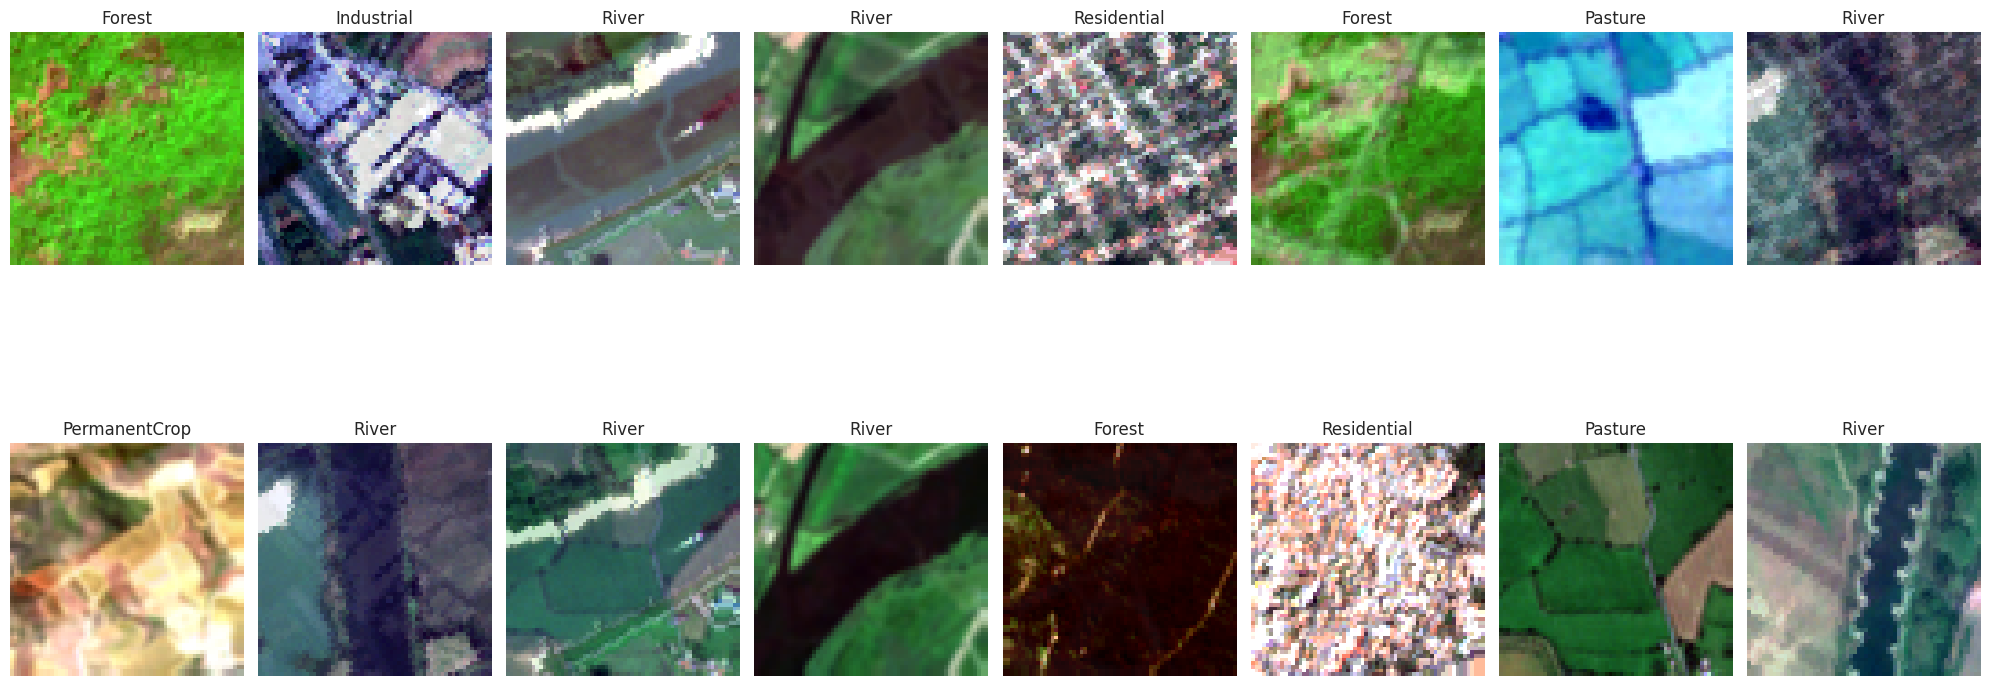

torch.Size([16, 4, 64, 64]) torch.Size([16, 10])


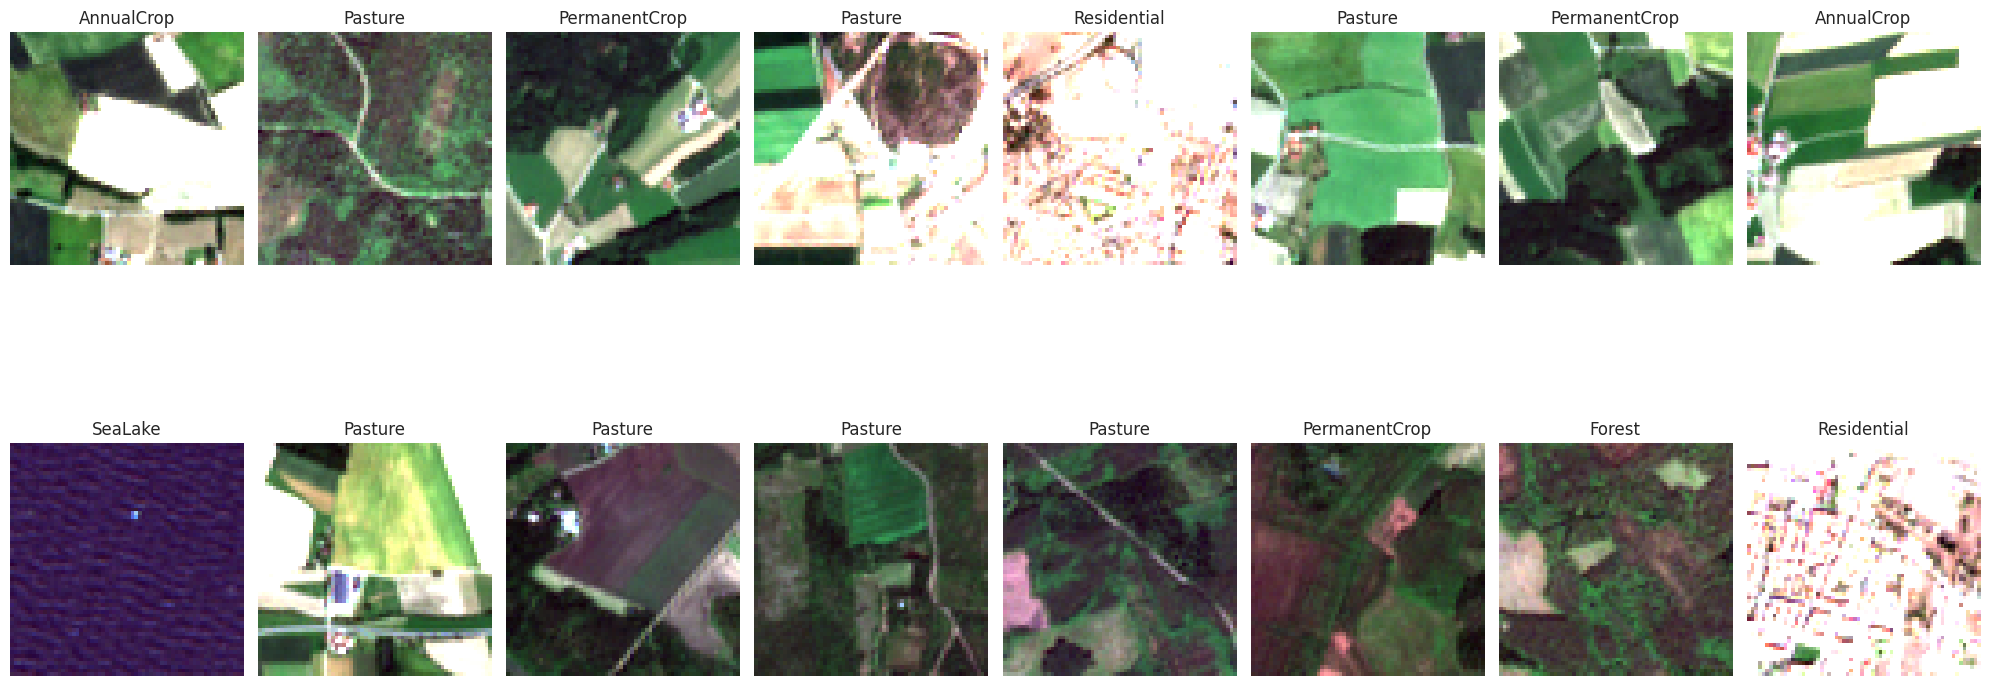

In [40]:
import matplotlib.pyplot as plt

chan = [3, 2, 1]
encoder = load_object(config.DATA_DIR + "on_hot_encoder")

def plot_images(img_batch, tar_batch):
    fig, axs = plt.subplots(2, 8, figsize=(20, 10))
    axs = axs.flatten()
    print(img_batch.shape, tar_batch.shape)
    for i, ax in enumerate(axs):
        
        img = img_batch[i].cpu().numpy()[[0, 1, 2]]
        lab = tar_batch[i].cpu().numpy().astype(float)
        
        title = encoder.categories_[0][lab.argmax()]

        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min + 1e-7)
        img = img.clip(0, 1)
        ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

dl_train = EuroSatDataLoader(ds_train, batch_size=16, shuffle=True, tf=data_transforms_l2c, augment=augmentation, mixup=True)
dl_val= EuroSatDataLoader(ds_val, batch_size=16, shuffle=False, tf=data_transforms_l2a, augment=None, mixup=False)

img_batch, tar_batch = next(iter(dl_train))
plot_images(img_batch, tar_batch)

img_batch, tar_batch = next(iter(dl_val))
plot_images(img_batch, tar_batch)

## Initialize the LightningDataModule and LightningModule

In [41]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

BATCH_SIZE = 32 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 50 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.005
DROPOUT_P = 0.3
GAMMA = 0.98

train_loader = EuroSatDataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, tf=data_transforms_l2c, augment=augmentation, mixup=True)
test_loader = EuroSatDataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, tf=data_transforms_l2a, augment=None, mixup=False)

In [42]:
# Create network
model = ResNet(ResidualBlock, [3, 2, 3], DROPOUT_P, in_channels=len(ds_train[0][0]), num_classes=NUM_CLASSES)
print(model)

if USE_CUDA:
    model = model.cuda()  

ResNet(
  (conv): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, ke

In [ ]:
model = ResNet(ResidualBlock, [1, 1, 1], DROPOUT_P, in_channels=len(ds_train[0][0]), num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("checkpoints/resnet_scratch/best_model_acc_64.11.pth"))
model.cuda()

In [43]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [44]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

best_val_accuracy = 0.0  # Variable to track the best validation accuracy
best_model_state_dict = None  # Variable to store the state_dict of the best model

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n{c.FAIL}Running epoch {epoch} of {NUM_EPOCHS}...{c.ENDC}\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    
    # Reset these below variables to 0 at the beginning of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()  # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()        
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation 
        optimizer.step()  # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        correct += (predicted == labels).sum()
        iterations += 1
        
        # if i % 100 == 0:
        #     print(f"{c.OKCYAN}Iteration {i} of {len(train_loader)}: {c.OKBLUE} Loss = {loss.item():.4f}{c.ENDC}")
        
    scheduler.step()
        
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(ds_train)))
     
    #-------------------------Test--------------------------
    
    correct = 0
    iterations = 0
    testing_loss = 0.0
    
    model.eval()  # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    current_val_accuracy = (100 * correct / len(ds_val))
    test_accuracy.append(current_val_accuracy)
    
    # Save the model if it has the best validation accuracy
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        best_model_state_dict = model.state_dict()
    
    print(f'{c.OKBLUE}train: Loss={train_loss[-1]:.4f} | Accuracy={train_accuracy[-1]:.4f}{c.ENDC}')
    print(f'{c.OKGREEN}val  : Loss={test_loss[-1]:.4f} | Accuracy={test_accuracy[-1]:.4f}{c.ENDC}')

# Save the best model
torch.save(best_model_state_dict, CKPT_PATH + f'best_model_acc_{best_val_accuracy:.2f}.pth')



Running epoch 1 of 50...

train: Loss=2.1463 | Accuracy=26.0936
val  : Loss=1.8781 | Accuracy=42.3729

Running epoch 2 of 50...

train: Loss=2.0077 | Accuracy=34.5965
val  : Loss=1.9136 | Accuracy=36.7896

Running epoch 3 of 50...

train: Loss=1.9249 | Accuracy=38.5887
val  : Loss=1.6239 | Accuracy=50.2493

Running epoch 4 of 50...

train: Loss=1.8639 | Accuracy=43.0487
val  : Loss=1.5531 | Accuracy=52.7418

Running epoch 5 of 50...

train: Loss=1.8083 | Accuracy=46.5965
val  : Loss=1.8522 | Accuracy=36.8893

Running epoch 6 of 50...

train: Loss=1.7704 | Accuracy=49.7232
val  : Loss=1.5485 | Accuracy=50.8475

Running epoch 7 of 50...

train: Loss=1.7181 | Accuracy=52.5263
val  : Loss=1.5234 | Accuracy=54.7358

Running epoch 8 of 50...

train: Loss=1.6810 | Accuracy=55.5322
val  : Loss=1.4788 | Accuracy=57.6271

Running epoch 9 of 50...

train: Loss=1.6476 | Accuracy=57.2437
val  : Loss=1.5309 | Accuracy=54.5364

Running epoch 10 of 50...

train: Loss=1.6193 | Accuracy=59.5361
val  : 

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Loss vs. Number of Epochs")
plt.plot(range(0, epoch), train_loss, label="Train")
plt.plot(range(0, epoch), test_loss, label="Test")
plt.plot(range(0, epoch), [a.item()/100 for a in test_accuracy], label="Test ACC")
plt.plot(range(0, epoch), [a.item()/100 for a in train_accuracy], label="Train ACC")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")

curr_lr = scheduler.get_last_lr()
summary = tabulate(
    [
        ["Best Val Acc", best_val_accuracy],
        ["Best Model", f"best_model_acc_{best_val_accuracy:.2f}.pth"],
        ["Learning Rate", curr_lr],
        ["Batch Size", BATCH_SIZE],
        ["Epochs", NUM_EPOCHS],
        ["Optimizer", "AdamW"],
        ["Weight Decay", WEIGHT_DECAY],
        ["Dropout", DROPOUT_P],
        ["Momentum", MOMENTUM],
        ["Gamma", GAMMA]
    ]
)
print(summary)

# predict on the validation set and plot the confusion matrix
predicted = []
true = []

model.load_state_dict(best_model_state_dict)
model.eval()
for i, (inputs, labels) in enumerate(dl_val):
    if USE_CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
    
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    _, labels = torch.max(labels, 1)
    encoded_labels = encoder.inverse_transform(labels.cpu().numpy().reshape(-1, 1))
    predicted.extend(pred.cpu().numpy())
    true.extend(encoded_labels)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(true, predicted))
cm = confusion_matrix(true, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.savefig("confusion_matrix.png")

In [ ]:
print(best_val_accuracy)

p, l, i = [], [], []
for f in os.listdir(config.TEST_MS_DIR):
    p.append(f)
    l.append("AnnualCrop")
    i.append(int(f.split('_')[1].split('.')[0]))

i, p, l = zip(* sorted(zip(i, p, l)))
data_sub = np.array([p, l]).transpose()
sub_df = pd.DataFrame(data_sub, columns=["path", "label"])

In [ ]:
data_sub = []
for f in os.listdir(config.TEST_MS_DIR):
    data_sub.append([f, "AnnualCrop"])

sub_df = pd.DataFrame(data_sub, columns=["path", "label"])

encoder = load_object(config.DATA_DIR + "on_hot_encoder")
dataset_sub = EuroSatMS(
    sub_df,
    config.TEST_MS_DIR,
    encoder=encoder,
    select_chan=CHANNELS_2A,
    dstype="test"
)

dataset = torch.utils.data.Dataset()
dataloader = EuroSatDataLoader(dataset_sub, batch_size=32, shuffle=True, num_workers=8, tf=data_transforms_l2a, mixup=False)

N_CLASSES = 10
categorys = encoder.categories_[0]
print(categorys)

In [ ]:
N_CLASSES = 10
categorys = encoder.categories_[0]
print(categorys)

In [ ]:
import torch
import numpy as np

device = "cuda"

model = ResNet(ResidualBlock, [2, 2, 2], DROPOUT_P, in_channels=len(ds_train[0][0]), num_classes=NUM_CLASSES)
model.load_state_dict(best_model_state_dict)
model.to(device)
model.eval()




In [ ]:
predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

    
with torch.no_grad():
    for batch_samp in dataloader:
        inputs, samp_id = batch_samp
        inputs = inputs.cuda()
            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = np.array(preds.cpu().numpy())
        
        pred_labels = np.array([categorys[p] for p in preds])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu().numpy())

In [ ]:
import pandas as pd

sample_ids = [int(s) for s in sample_ids]

submission_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
submission_df = submission_df.sort_values(by='test_id')
print(submission_df.head())

submission_df.to_csv('submission.csv', index=False)
print(np.unique(predictions, return_counts=True))

In [ ]:
import torch
import random
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5

for param in model_eval.backbone.parameters():
    param.requires_grad = True


for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        im_path = config.DATA_DIR + f"test/NoLabel/test_{samp_id}.npy"
        # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[3, 2, 1]].astype(np.float32)
        
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)
        img = img.clip(0, 1)
        ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(pred, fontsize=20)
        ax.axis('off')
        

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Hyperparameter Tuning

In [ ]:
HP_RESULTS_PATH = "hp_results/hp_results.csv"

hp_results = pd.DataFrame(
    columns=[
        "model", "batch_size", "lr", "wd", "layers", "optimizer",
        "train_loss_1", "train_loss_2", "val_loss_1", "val_loss_2",
        "val_acc_1", "val_acc_2", "num_freez", "ep_val_acc", "epochs"
        ]
    )

c_i = 0
while os.path.isfile(HP_RESULTS_PATH):
    HP_RESULTS_PATH = f"hp_results/hp_results_{c_i}.csv"
    c_i+=1

hp_results.to_csv(HP_RESULTS_PATH, index=False)

In [ ]:
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger


# Fix parameters
GAMMA = 0.9
MOMENTUM = 0.9
DROPOUT = 0.4

# Function to perform a single hyperparameter tuning run
def train_eurosat(config):
    model, _ = get_pretrained_model(config["model"])

    data_module = EuroSatDataModule(ds_train, ds_val, ds_test, config["batch_size"])

    model_train = EuroSatPreTrainedModel(
        backbone=model,
        learning_rate=config["lr"],
        layers=config["head_layers"],
        opt=config["optimizer"],
        gamma=GAMMA,
        momentum=MOMENTUM,
        dropout=DROPOUT,
        weight_decay=config["weight_decay"],
    )
    run_name = str(config["model"])
    run_id = str(hash(run_name + str(config)))
    logger = CSVLogger(save_dir='logs/', name=run_name, version=run_id)

    checkpoint_callback = ModelCheckpoint(
        dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
        filename='{epoch:02d}-{val_loss:.2f}-{train_loss_epoch:.2f}',
        save_top_k=1,
        monitor="val_loss",
        verbose=False
    )

    early_stopping = EarlyStopping(
        monitor="val_train_div",
        patience=20, mode="max",
        stopping_threshold=0.3
    )

    trainer = Trainer(
        max_epochs=config["ep_freez"],
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
    )
    print(float(config["unfreez_layers_p"] / 2))
    model_train.unfreeze_layers(float(config["unfreez_layers_p"] / 2))
    trainer.fit(model_train, datamodule=data_module)

    val_acc_1 = trainer.callback_metrics.get("val_acc").item()
    val_loss_1 = trainer.callback_metrics.get("val_loss").item()
    ep_loss_1 = trainer.callback_metrics.get("train_loss_epoch").item()

    model_train.unfreeze_layers(config["unfreez_layers_p"])

    trainer = Trainer(
        max_epochs=config["ep_unfreez"],
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
    )

    # Second phase of training, continuing from the last state
    trainer.fit(model_train, datamodule=data_module)

    ep_loss_2 = trainer.callback_metrics.get("train_loss_epoch").item()
    val_acc_2 = trainer.callback_metrics.get("val_acc").item()
    val_loss_2 = trainer.callback_metrics.get("val_loss").item()

    metrics_df = pd.read_csv(f'logs/{run_name}/{run_id}/metrics.csv')
    ep_val_acc = metrics_df[['epoch', 'val_acc']].dropna()
    val_acc = ep_val_acc[['val_acc']].values
    epochs = ep_val_acc[['epoch']].values

    hp_results = pd.read_csv(HP_RESULTS_PATH)

    hp_results.loc[len(hp_results) + 1] = [
        config["model"], config["batch_size"], config["lr"], config["weight_decay"],
        config["head_layers"], config["optimizer"], ep_loss_1, ep_loss_2, val_loss_1,
        val_loss_2, val_acc_1, val_acc_2, config["unfreez_layers_p"], val_acc, epochs]
    print(hp_results.loc[len(hp_results)])
    hp_results.to_csv(HP_RESULTS_PATH, index=False)




In [ ]:
from itertools import product

hp_param_grid = {
    "model": [
        "resnet50_RGB",
        "vit_b_16",
        # "vgg19",
        "swin_v2_t",
        # "mobilenet_v3_small",
        # "googlenet",
        # "efficientnet_v2_s"
    ],
    "ep_freez": [10],
    "ep_unfreez": [5],
    "unfreez_layers_p": [0.3, 0.5, 0.7],
    "batch_size": [32, 64, 256],
    "lr": [0.0005, 0.00025, 0.0001, 0.000075, 0.00005, 0.000025],
    "head_layers": [[]],
    "optimizer": ["adam"],
    "weight_decay": [0.01, 0.005, 0.001, 0.0005, 0.0001]
}

combinations = product(*hp_param_grid.values())

# Create a list to store the hyperparameter dictionaries
hyperparameter_configs = []

# Loop through each combination and create a dictionary
for combination in combinations:
    hyperparameter_config = {}
    for param_name, param_value in zip(hp_param_grid.keys(), combination):
        hyperparameter_config[param_name] = param_value
    hyperparameter_configs.append(hyperparameter_config)

print("Total Iterations: ", len(hyperparameter_configs))

In [ ]:
import random

seed_everything(36)

random.shuffle(hyperparameter_configs)

for i in range(len(hyperparameter_configs)):
    print("Itteration: ", i)
    print(hyperparameter_configs[i])
    train_eurosat(hyperparameter_configs[i])

In [ ]:
torch.cuda.empty_cache()

# Analyze Results

In [ ]:
import pandas as pd

HP_RESULTS_PATH = "/content/drive/MyDrive/EuroSat_LUC/hp_results_1.csv"

cols = ['model', 'batch_size', 'lr', 'wd', 'optimizer', 'val_acc_1', 'val_acc_2']
df = pd.read_csv(HP_RESULTS_PATH)
print(df.columns)

df = df.sort_values(by=["val_acc_1"], ascending=False)
print(df.head(10))